In [25]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt

# Configuration
depth = 2 # or any value > 1
n_qubits = 4
n_params = n_qubits * depth
param_vector = ParameterVector("theta", n_params)
print(n_params)

# --- Hamiltonian: Nearest-neighbor Z_i Z_{i+1} (Ising-type) ---
H_terms = []
for i in range(n_qubits - 1):
    z_str = ['I'] * n_qubits
    z_str[i] = 'Z'
    z_str[i + 1] = 'Z'
    H_terms.append(("".join(z_str), 1.0))
    
H = SparsePauliOp.from_list(H_terms)

# --- Ansatz Generator ---
def make_ansatz():
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for d in range(depth):
        for i in range(n_qubits):
            qc.ry(param_vector[idx], i)
            idx += 1
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
    return qc


8


In [26]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import Aer
from qiskit_aer import AerSimulator

# estimator = Estimator()
ansatz = make_ansatz()
estimator = Estimator()

# sim = AerSimulator()
# job = sim.run(circuit, shots=1000)
# counts = job.result().get_counts()


/var/folders/0l/hvh0rb_x7w72hgcx0h1d6crm0000gn/T/ipykernel_19007/1198814795.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


# Ansatz Circuit

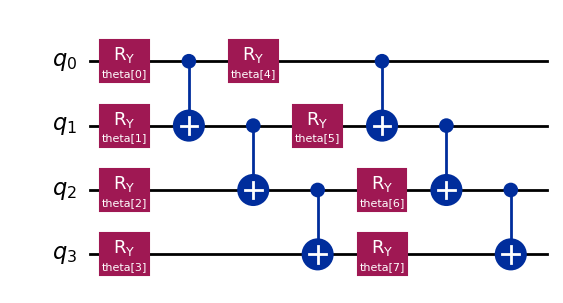

In [27]:
from qiskit.visualization import circuit_drawer

circuit = make_ansatz()
circuit.draw('mpl')  # For matplotlib-style plot

In [28]:
# Objective function
def objective(theta):
    result = estimator.run([ansatz], [H], [theta]).result()
    return result.values[0].real


# BO

In [29]:
# Bayesian Optimization
space = [Real(-np.pi, np.pi) for _ in range(n_params)]
bo_result = gp_minimize(objective, space, n_calls=30, n_initial_points=5, acq_func='EI', random_state=0)
bo_func_vals = bo_result.func_vals
bo_best_vals = np.minimum.accumulate(bo_func_vals)

# Cobyla

In [30]:
# COBYLA
grad_result_vals = []
grad_best_vals = []
def callback(theta):
    val = objective(theta)
    grad_result_vals.append(val)
    grad_best_vals.append(min(grad_result_vals))

x0 = np.random.uniform(-np.pi, np.pi, size=n_params)
_ = minimize(objective, x0, method='COBYLA', callback=callback, options={'maxiter': 30})

# Exact Ground Energy

In [31]:
from qiskit.quantum_info import Operator

# --- Compute theoretical minimum energy from full Hamiltonian ---
def get_ground_energy(H):
    H_matrix = Operator(H).data
    eigenvalues = np.linalg.eigvalsh(H_matrix)
    return np.min(eigenvalues)

theoretical_min_energy = get_ground_energy(H)
print(f"🎯 Theoretical ground energy: {theoretical_min_energy:.6f}")

🎯 Theoretical ground energy: -3.000000


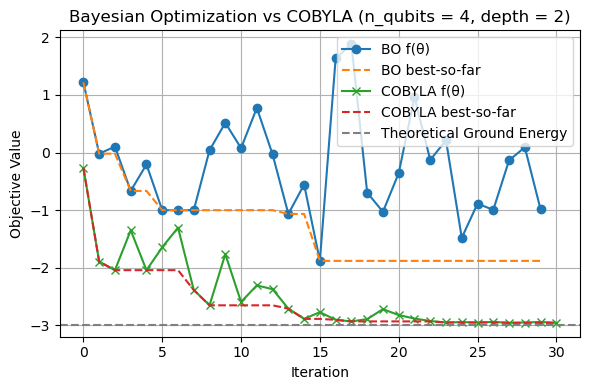

In [32]:
# Plot comparison
plt.figure(figsize=(6, 4))
plt.plot(bo_func_vals, label="BO f(θ)", marker='o')
plt.plot(bo_best_vals, '--', label="BO best-so-far")
plt.plot(grad_result_vals, label="COBYLA f(θ)", marker='x')
plt.plot(grad_best_vals, '--', label="COBYLA best-so-far")
plt.axhline(theoretical_min_energy, color='gray', linestyle='--', label='Theoretical Ground Energy')
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title(f"Bayesian Optimization vs COBYLA (n_qubits = {n_qubits}, depth = {depth})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
